DenseNet, or Dense Convolutional Network, is a deep learning architecture that promotes feature reuse by connecting each layer to every other layer in a dense block. This design was introduced in the paper "Densely Connected Convolutional Networks" by Gao Huang et al. in 2017. 

It stands out for its efficiency in feature propagation, reuse of feature maps, and reduction in the number of parameters.

The primary difference between DenseNet-121, DenseNet-169, DenseNet-201, and DenseNet-161 lies in the depth of the network, which corresponds to the number of layers and the number of parameters in each model. Let’s break down the architecture, focusing on key components.

Features of DenseNet:
Dense Blocks: 

DenseNet consists of dense blocks, where the layers within each block are densely connected. Between dense blocks, there are transition layers, which include:

1x1 convolution to reduce the number of feature maps.
Pooling layer (2x2 average pooling) to reduce the spatial dimensions of the feature maps.

Bottleneck Layers: Bottleneck layers (1x1 convolutions) are used before the 3x3 convolutions to reduce the number of input feature maps and, hence, the computational complexity. DenseNet uses bottleneck layers in some versions (DenseNet-121, DenseNet-169, DenseNet-201) to make the architecture more efficient.

Classification Layer: In the original DenseNet (used for classification), after the final dense block, global average pooling is applied, followed by a fully connected layer and softmax activation for classification.

Pytorch training

In [23]:
import os
import numpy as np
import time
from IPython.utils import io
from collections import OrderedDict

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
import gc

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches  # Import mpatches here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [25]:
import torch
import gc

# Clear cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

297

In [26]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [27]:
import torch

def check_and_clear_cuda_memory():
    """
    Checks the current CUDA memory usage and clears the cache.
    """
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()  # Clear cached memory
        print("CUDA cache cleared.")
    else:
        print("CUDA is not available.")


In [28]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [29]:
# Call the function directly in the code where needed
check_and_clear_cuda_memory()

CUDA memory allocated: 122814464
CUDA memory reserved: 226492416
CUDA cache cleared.


In [30]:
data_path = '/kaggle/input/medical-images/cs604_projects_dataset'
# List the contents of the data directory
print(os.listdir(data_path))

# image_dir = '/kaggle/input/cs604-project/train_images/'
# mask_dir = '/kaggle/input/cs604-project/train_masks/'

image_dir = f'{data_path}/train_images/'
mask_dir = f'{data_path}/train_masks/'

all_filenames = sorted(os.listdir(image_dir))

# define class_names
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
num_classes = len(class_names)

['train_images', 'train_masks']


In [31]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_path = '/kaggle/input/cs604-project/cs604_projects_dataset'

# List the contents of the data directory
print(os.listdir(data_path))

# List the contents of the data directory
print(os.listdir(data_path))

# Dataset setup
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))  # Load filenames internally
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1117.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_0205.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1515.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1224.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1453.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1200.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1092.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_0153.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_0966.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1019.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_0757.png
/kaggle/input/cs604-project/cs604_projects_dataset/train_images/train_1299.png
/kaggle/input/cs604-project/cs604_projects_dataset/t

In [33]:
total_images = len(all_filenames)

# Calculate the number of images for each set
train_size = int(0.90 * total_images)
val_size = int(0.10 * total_images)
# test_size = total_images - train_size - val_size  # Adjust for any rounding errors

print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")
# print(f"Test images: {test_size}")

Training images: 1467
Validation images: 163


In [34]:
# First split into training and temp (validation + test)
train_filenames, val_filenames = train_test_split(all_filenames,test_size=(val_size),random_state=42)

# Now split temp into validation and test
# val_filenames, test_filenames = train_test_split(temp_filenames,test_size=test_size,random_state=42)

print(f"Total images: {len(all_filenames)}")
print(f"Training images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
# print(f"Test images: {len(test_filenames)}")  

torch.manual_seed(42)

Total images: 1631
Training images: 1468
Validation images: 163


Helper function

In [35]:
def check_and_clear_cuda_memory(device):
    """
    Check the allocated and reserved CUDA memory for the specified device,
    clear the CUDA cache, and collect garbage.

    Parameters:
    device (torch.device): The CUDA device to check memory for.
    """
    if torch.cuda.is_available():
        # Check memory allocated and reserved
        allocated_memory = torch.cuda.memory_allocated(device)
        reserved_memory = torch.cuda.memory_reserved(device)

        print(f"Memory Allocated: {allocated_memory / (1024 ** 2):.2f} MB")
        print(f"Memory Reserved: {reserved_memory / (1024 ** 2):.2f} MB")

        # Clear the CUDA cache
        torch.cuda.empty_cache()
        
        # Help clear up any remaining references
        gc.collect()
        print("Cleared CUDA cache and remaining references.")
    else:
        print("CUDA is not available on this device.")

def plot_ordered_dict(ordered_dict):
    # Extract` keys and values from the ordered dictionary
    keys = list(ordered_dict.keys())
    values = list(ordered_dict.values())
    
    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    
    # Add title and labels
    plt.title('Bar Chart from Ordered Dictionary')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    
    # Show the plot
    plt.show()

def calculate_weight_tensors(class_counts):
    # Calculate the total number of samples
    total_samples = sum(class_counts)
    
    # Calculate the inverse frequency for each class
    weights = [total_samples / count for count in class_counts]
    
    # Convert the list of weights to a tensor
    weight_tensors = torch.tensor(weights, dtype=torch.float32)
    
    return weight_tensors

def calculate_elapsed_time(start):
    # Convert elapsed time to hours, minutes, seconds, and milliseconds
    elapsed_time = time.time() - start
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = (seconds - int(seconds)) * 1000

    # Print the results
    print ('\n')
    print("=" * 100)
    print(f"Total runtime: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds, {int(milliseconds)} milliseconds")
    print("=" * 100, '\n')

def plot_learning_curves(train_losses, val_losses, train_miou, val_miou, learning_rates, save_path='lc_plots/lc_plot.png'):
    """
    Plots the training and validation learning curves for losses, mIoU, and learning rates on secondary axes.
    
    Parameters:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - train_miou: List of training mIoU values.
    - val_miou: List of validation mIoU values.
    - learning_rates: List of learning rates used during training.
    - save_path (str): The name of the file to save the plot (default: 'lc_plots/lc_plot.png').
    """
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # Side by side subplots
    
    # Plot training and validation losses
    ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
    ax1.plot(val_losses, label='Validation Loss', color='orange', marker='o')
    
    # Add labels and title for the first subplot
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()

    # Create a secondary y-axis for learning rates on the first subplot
    ax1_lr = ax1.twinx()
    
    # Plot learning rates on the secondary y-axis
    ax1_lr.plot(learning_rates, label='Learning Rate', color='purple', marker='x', alpha=0.5)
    
    # Add labels for the secondary axis
    ax1_lr.set_ylabel('Learning Rate')

    # Combine legends for the first subplot
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles_lr1, labels_lr1 = ax1_lr.get_legend_handles_labels()
    
    # Combine handles and labels for the first subplot
    handles_combined_1 = handles1 + handles_lr1
    labels_combined_1 = labels1 + labels_lr1
    
    # Create a single legend for the first subplot
    ax1.legend(handles_combined_1, labels_combined_1, loc='upper right')

    # Plot training and validation mIoU
    ax2.plot(train_miou, label='Training mIoU', color='blue', marker='o')
    ax2.plot(val_miou, label='Validation mIoU', color='orange', marker='o')
    
    # Add labels and title for the second subplot
    ax2.set_title('Training and Validation mIoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean IoU')
    ax2.grid()

    # Create a secondary y-axis for learning rates on the second subplot
    ax2_lr = ax2.twinx()
    
    # Plot learning rates on the secondary y-axis
    ax2_lr.plot(learning_rates, label='Learning Rate', color='purple', marker='x', alpha=0.5)
    
    # Add labels for the secondary axis
    ax2_lr.set_ylabel('Learning Rate')

    # Combine legends for the second subplot
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles_lr2, labels_lr2 = ax2_lr.get_legend_handles_labels()
    
    # Combine handles and labels for the second subplot
    handles_combined_2 = handles2 + handles_lr2
    labels_combined_2 = labels2 + labels_lr2
    
    # Create a single legend for the second subplot
    ax2.legend(handles_combined_2, labels_combined_2, loc='lower right')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(save_path, format='png')
    print(f"Train and validation mIoU and loss plots saved as '{save_path}'")
    # Show the plot
    plt.show()

def compute_iou(preds, labels, num_classes):
    """
    Computes IoU for each class between predicted labels and ground truth labels.

    Args:
        preds (torch.Tensor): Predicted labels, shape (N, H, W)
        labels (torch.Tensor): Ground truth labels, shape (N, H, W)
        num_classes (int): Number of classes

    Returns:
        list: IoU for each class
    """
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = torch.sum((pred_inds & target_inds).float()).item()
        union = torch.sum((pred_inds | target_inds).float()).item()
        if union == 0:
            iou = float('nan')  # If there is no ground truth, set IoU to NaN
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

Dataset Loader

In [36]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name  # Filenames match
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

    def get_class_sample_count(self):
        """
        Returns the number of training samples per class based on the masks.
        
        Returns:
            dict: A dictionary where keys are class labels and values are counts of samples.
        """
        sample_counts = {}
        
        for img_name in self.image_filenames:
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)

            # Get unique classes in the mask
            unique_classes = np.unique(mask_array)

            # Count this image for each unique class present
            for cls in unique_classes:
                if cls not in sample_counts:
                    sample_counts[cls] = 1
                else:
                    sample_counts[cls] += 1

        # Sort the dictionary by keys and convert to OrderedDict
        sorted_sample_counts = OrderedDict(sorted(sample_counts.items()))
        
        return sorted_sample_counts
    
    def get_class_distribution(self):
        """
        Returns the number of training samples per class based on the masks.
        
        Returns:
            dict: A dictionary where keys are class labels and values are counts of samples.
        """
        class_counts = {}
        
        for img_name in self.image_filenames:
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)

            # Count unique classes in the mask
            unique_classes, counts = np.unique(mask_array, return_counts=True)

            for cls, count in zip(unique_classes, counts):
                if cls not in class_counts:
                    class_counts[cls] = count
                else:
                    class_counts[cls] += count
        
        return class_counts
    
    def plot_class_distribution(self):
        """
        Plots a bar chart of the class distribution.
        """
        class_distribution = self.get_class_distribution()

        # Prepare data for plotting, excluding class 0
        filtered_classes = {k: v for k, v in class_distribution.items() if k != 0}
        
        # Prepare data for plotting
        classes = list(filtered_classes.keys())
        counts = list(filtered_classes.values())

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts, color='skyblue')
        
        plt.xlabel('Class Labels')
        plt.ylabel('Pixel Count')
        plt.title('Class Distribution in Dataset')
        
        # Optionally set x-ticks to be more readable if there are many classes
        plt.xticks(classes)
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.show()


In [15]:
# train_transform_image = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])

In [16]:
# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

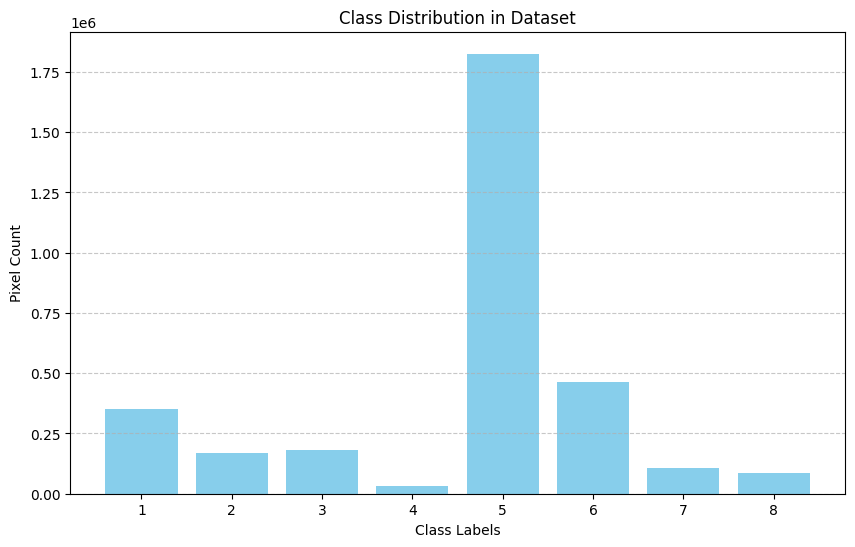

In [16]:
val_dataset.plot_class_distribution()

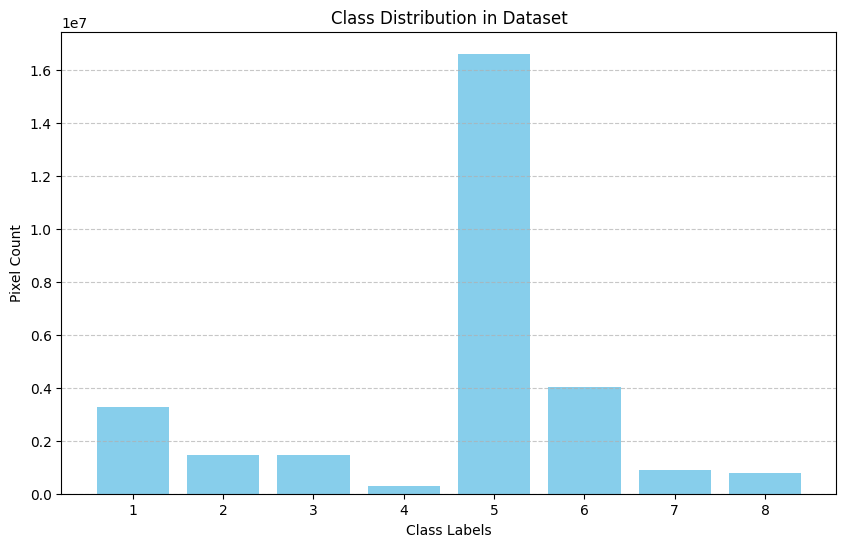

In [17]:
train_dataset.plot_class_distribution()

OrderedDict([(0, 1468), (1, 596), (2, 615), (3, 619), (4, 266), (5, 1066), (6, 705), (7, 1401), (8, 525)])


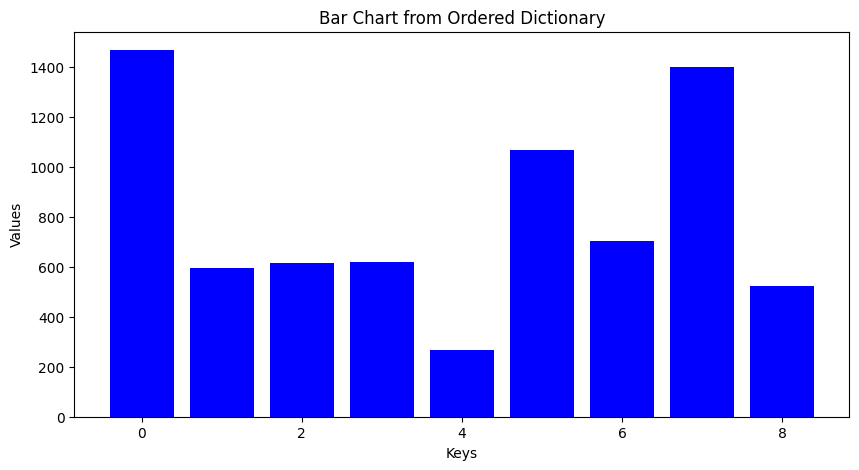

In [18]:
print(train_dataset.get_class_sample_count())
plot_ordered_dict(train_dataset.get_class_sample_count())

OrderedDict([(0, 163), (1, 73), (2, 70), (3, 74), (4, 29), (5, 121), (6, 82), (7, 154), (8, 58)])


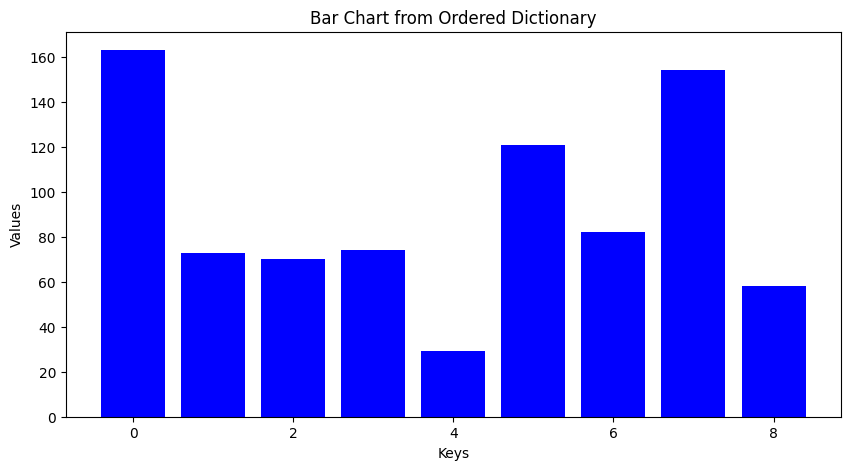

In [19]:
print(val_dataset.get_class_sample_count())
plot_ordered_dict(val_dataset.get_class_sample_count())

In [17]:
# Get and print the number of training samples per class
class_sample_count = train_dataset.get_class_sample_count()

train_samples_per_class = []
# Print the number of training samples per class
for class_label, count in class_sample_count.items():
    print(f"Class {class_label}: {count} samples")
    train_samples_per_class.append(count)

print (train_samples_per_class)

# Get weighted tensors for doing weighted cross entropy loss
weight_tensors = calculate_weight_tensors(train_samples_per_class)

print("weight tensors: ", weight_tensors)

Class 0: 1468 samples
Class 1: 596 samples
Class 2: 615 samples
Class 3: 619 samples
Class 4: 266 samples
Class 5: 1066 samples
Class 6: 705 samples
Class 7: 1401 samples
Class 8: 525 samples
[1468, 596, 615, 619, 266, 1066, 705, 1401, 525]
weight tensors:  tensor([ 4.9462, 12.1829, 11.8065, 11.7302, 27.2970,  6.8114, 10.2993,  5.1827,
        13.8305])


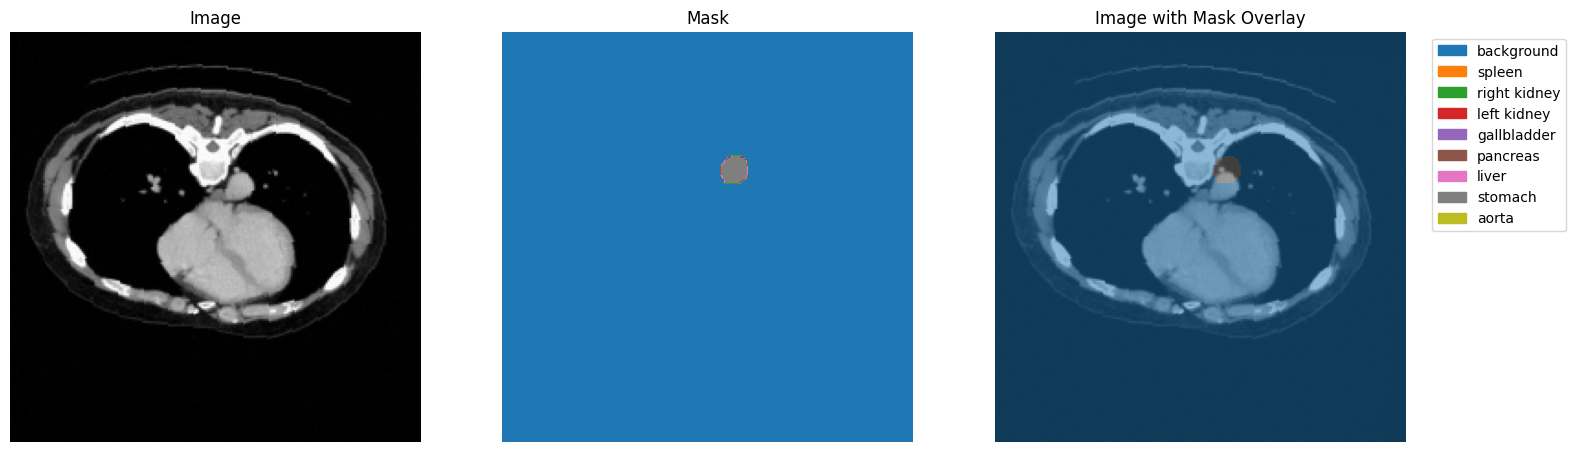

In [21]:
def visualize_sample(dataset, idx=None, filename=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors as mcolors
    from PIL import Image

    # Load image and mask
    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")

    # Prepare image for visualization
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.numpy()

    # Define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors
    colormap = mcolors.ListedColormap(colors[:9])

    # Create color mask
    mask_rgba = colormap(mask_np / 8.0)
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # Plot image and mask
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask_np, cmap=colormap, vmin=0, vmax=8)
    ax2.set_title('Mask')
    ax2.axis('off')

    ax3.imshow(image_np)
    ax3.imshow(mask_rgba, interpolation='none')
    ax3.set_title('Image with Mask Overlay')
    ax3.axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

visualize_sample(train_dataset, idx=1)

Model DenseNet

The DenseNet architecture, especially when adapted for segmentation as shown here, has several unique characteristics that set it apart from other convolutional neural network (CNN) architectures. Let's go over its main characteristics:

1. Dense Connectivity (Feature Reuse)
Characteristic: In DenseNet, each layer is connected to every other layer in a dense block, meaning the output of each layer is used as input for every subsequent layer within the same block.
Advantage: This dense connectivity allows for efficient feature reuse, where early layers provide foundational features that are enhanced by later layers. This enables the network to learn richer features without needing to increase the number of parameters significantly.
Benefit: Dense connectivity improves gradient flow, which helps mitigate vanishing gradients and makes it easier to train deeper networks.

2. Parameter Efficiency
Characteristic: DenseNet is more parameter-efficient compared to traditional CNNs like ResNet, as it doesn't need as many filters in each layer.
Advantage: DenseNet uses fewer parameters because the network can rely on previously computed feature maps instead of recreating similar features in each layer. Each layer receives the cumulative knowledge of previous layers.
Benefit: This makes DenseNet less prone to overfitting, especially on smaller datasets, and enables it to achieve high performance with fewer parameters than architectures of similar depth.

3. Growth Rate (growth_rate Parameter)
Characteristic: DenseNet introduces a parameter called the "growth rate," which controls how many new feature maps each layer adds to the network.
Advantage: By adjusting the growth rate, DenseNet can control the network's memory and computational requirements, making it adaptable for various tasks with different resource constraints.
Benefit: Lower growth rates result in more compact models, while higher growth rates provide increased representational capacity but require more memory.

4. Transition Layers for Downsampling
Characteristic: DenseNet includes transition layers between dense blocks, which consist of batch normalization, a 1x1 convolution, and a downsampling operation (usually an average pooling layer).
Advantage: These layers reduce the number of feature maps and spatial dimensions, which keeps the network efficient in terms of memory and computation.
Benefit: Transition layers help control model complexity by reducing spatial resolution and feature map count, allowing DenseNet to scale well to deeper architectures.

5. High-Resolution Outputs with Upsampling for Segmentation
Characteristic: In segmentation adaptations of DenseNet, upsampling layers are added to restore the spatial dimensions of the output to match the input size (e.g., 224x224).
Advantage: This makes DenseNet suitable for tasks like semantic segmentation, where dense pixel-wise predictions are needed.
Benefit: By using an upsampling layer (e.g., bilinear upsampling) at the end, DenseNet can produce high-resolution output maps that align with the input dimensions for pixel-level tasks.

6. Batch Normalization and Activation Layers in Dense Layers
Characteristic: Each layer in DenseNet’s dense blocks applies batch normalization, a ReLU activation, and either a 1x1 or 3x3 convolution.
Advantage: This combination improves stability, allows the network to converge faster, and reduces the chance of overfitting.
Benefit: DenseNet benefits from improved gradient flow due to batch normalization, and ReLU activation adds non-linearity, which enhances the network’s ability to learn complex functions.

7. Better Gradient Flow
Characteristic: The direct connections between all layers in a dense block allow gradients to flow more easily through the network during backpropagation.
Advantage: Improved gradient flow addresses the vanishing gradient problem and allows DenseNet to achieve deeper architectures without loss of gradient strength.
Benefit: DenseNet can be trained with fewer epochs and still achieve high accuracy, as gradients don’t degrade as they flow through the network.
Summary of Characteristics for the Adapted DenseNet Model
For a segmentation model like the one we’ve implemented here:

Dense connectivity ensures efficient feature reuse, beneficial for fine-grained pixel-wise prediction.

Parameter efficiency helps the model generalize better on limited data, which is often the case in segmentation tasks.

Upsampling allows for high-resolution output required for dense predictions in segmentation.

Transition layers balance memory and computation by downsampling while maintaining feature richness.

Growth rate offers flexibility in model size and complexity to fit different computational budgets.


Data Augmentation: train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

No skip connections + Cross Entropy Loss

In [22]:
# Imports (consolidated)
import os
import time
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

# Custom Dataset
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Define DenseNet layers and blocks
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=9):
        super(DenseNet, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module(f'denseblock{i + 1}', block)
            num_features = num_features + num_layers * growth_rate
            
            # Transition Layer between dense blocks (not after the last dense block)
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        
        # Classifier layer for segmentation: 1x1 convolution to reduce to `num_classes` channels
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)

        # Upsampling layer to match input dimensions (224x224)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = self.classifier(x)         # Output shape: (batch_size, num_classes, 7, 7)
        x = self.upsample(x)           # Upsample to (batch_size, num_classes, 224, 224)
        return x
    
# Instantiate and print the model to verify
model = DenseNet(num_classes=9).to(device)
print(model)

CUDA memory allocated: 0
CUDA memory reserved: 0
CUDA cache cleared.
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _DenseLayer(
          (bn1): Ba

In [23]:
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

set_seed(42)

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers =4)

    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNet(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensors.to(device))  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device,
    bs=16,
    patience=10,
    save_path='models/best_model.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

Epoch [1/50], Learning rate: 0.001000, Training Loss: 0.2740, Train mIoU: 0.2939, Validation Loss: 0.1661, Validation mIoU: 0.3424
Improved validation mIoU, saving model to models/best_model.pth...
Class 0 (background): IoU = 0.9592
Class 1 (spleen): IoU = 0.4392
Class 2 (right kidney): IoU = 0.2651
Class 3 (left kidney): IoU = 0.1605
Class 4 (gallbladder): IoU = 0.1757
Class 5 (pancreas): IoU = 0.6099
Class 6 (liver): IoU = 0.4372
Class 7 (stomach): IoU = 0.0044
Class 8 (aorta): IoU = 0.0307
Epoch [2/50], Learning rate: 0.001000, Training Loss: 0.1563, Train mIoU: 0.3762, Validation Loss: 0.1361, Validation mIoU: 0.4000
Improved validation mIoU, saving model to models/best_model.pth...
Class 0 (background): IoU = 0.9613
Class 1 (spleen): IoU = 0.5150
Class 2 (right kidney): IoU = 0.3168
Class 3 (left kidney): IoU = 0.2962
Class 4 (gallbladder): IoU = 0.1902
Class 5 (pancreas): IoU = 0.6865
Class 6 (liver): IoU = 0.5344
Class 7 (stomach): IoU = 0.0019
Class 8 (aorta): IoU = 0.0973
Epoc

/tmp/ipykernel_15184/3047168525.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Test Loss: 0.0735, Test mIoU: 0.6051
Class 0 (background): IoU = 0.9740
Class 1 (spleen): IoU = 0.7052
Class 2 (right kidney): IoU = 0.6111
Class 3 (left kidney): IoU = 0.6036
Class 4 (gallbladder): IoU = 0.3694
Class 5 (pancreas): IoU = 0.8025
Class 6 (liver): IoU = 0.7559
Class 7 (stomach): IoU = 0.2580
Class 8 (aorta): IoU = 0.3660


Trying Skip connections + (dice loss + cross entropy)

In [24]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

CUDA memory allocated: 122159616
CUDA memory reserved: 2376073216
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

In [25]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [26]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [27]:
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

set_seed(42)

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_2.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_2.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

Epoch [1/250], Learning rate: 0.001000, Training Loss: 1.2056, Train mIoU: 0.1966, Validation Loss: 1.2849, Validation mIoU: 0.1828
Improved validation mIoU, saving model to models/best_model_2.pth...
Class 0 (background): IoU = 0.9428
Class 1 (spleen): IoU = 0.1718
Class 2 (right kidney): IoU = 0.0391
Class 3 (left kidney): IoU = 0.0007
Class 4 (gallbladder): IoU = 0.0000
Class 5 (pancreas): IoU = 0.3997
Class 6 (liver): IoU = 0.0355
Class 7 (stomach): IoU = 0.0558
Class 8 (aorta): IoU = 0.0000
Epoch [2/250], Learning rate: 0.001000, Training Loss: 0.9073, Train mIoU: 0.3327, Validation Loss: 0.7211, Validation mIoU: 0.4330
Improved validation mIoU, saving model to models/best_model_2.pth...
Class 0 (background): IoU = 0.9602
Class 1 (spleen): IoU = 0.5057
Class 2 (right kidney): IoU = 0.4082
Class 3 (left kidney): IoU = 0.3304
Class 4 (gallbladder): IoU = 0.2393
Class 5 (pancreas): IoU = 0.7078
Class 6 (liver): IoU = 0.3746
Class 7 (stomach): IoU = 0.2377
Class 8 (aorta): IoU = 0.133

/tmp/ipykernel_15184/3494771051.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_2.pth'))


Test Loss: 0.2956, Test mIoU: 0.7175
Class 0 (background): IoU = 0.9814
Class 1 (spleen): IoU = 0.7756
Class 2 (right kidney): IoU = 0.7102
Class 3 (left kidney): IoU = 0.7280
Class 4 (gallbladder): IoU = 0.5354
Class 5 (pancreas): IoU = 0.8453
Class 6 (liver): IoU = 0.7777
Class 7 (stomach): IoU = 0.6238
Class 8 (aorta): IoU = 0.4805


New data augmentation: Removing gaussian

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise #     transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [28]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

CUDA memory allocated: 122568704
CUDA memory reserved: 3680501760
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

In [29]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [30]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [31]:
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

set_seed(42)

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_3.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_3.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

Epoch [1/250], Learning rate: 0.001000, Training Loss: 1.2048, Train mIoU: 0.1987, Validation Loss: 0.9800, Validation mIoU: 0.2655
Improved validation mIoU, saving model to models/best_model_3.pth...
Class 0 (background): IoU = 0.9522
Class 1 (spleen): IoU = 0.3001
Class 2 (right kidney): IoU = 0.2161
Class 3 (left kidney): IoU = 0.0273
Class 4 (gallbladder): IoU = 0.0000
Class 5 (pancreas): IoU = 0.5624
Class 6 (liver): IoU = 0.1488
Class 7 (stomach): IoU = 0.1406
Class 8 (aorta): IoU = 0.0420
Epoch [2/250], Learning rate: 0.001000, Training Loss: 0.8885, Train mIoU: 0.3406, Validation Loss: 0.8174, Validation mIoU: 0.3807
Improved validation mIoU, saving model to models/best_model_3.pth...
Class 0 (background): IoU = 0.9530
Class 1 (spleen): IoU = 0.4929
Class 2 (right kidney): IoU = 0.3347
Class 3 (left kidney): IoU = 0.2635
Class 4 (gallbladder): IoU = 0.0000
Class 5 (pancreas): IoU = 0.6702
Class 6 (liver): IoU = 0.3570
Class 7 (stomach): IoU = 0.2337
Class 8 (aorta): IoU = 0.121

/tmp/ipykernel_15184/1522186867.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_3.pth'))


Test Loss: 0.2597, Test mIoU: 0.7449
Class 0 (background): IoU = 0.9834
Class 1 (spleen): IoU = 0.8161
Class 2 (right kidney): IoU = 0.7323
Class 3 (left kidney): IoU = 0.7566
Class 4 (gallbladder): IoU = 0.5928
Class 5 (pancreas): IoU = 0.8568
Class 6 (liver): IoU = 0.7973
Class 7 (stomach): IoU = 0.6761
Class 8 (aorta): IoU = 0.4931


New data augmentation: Removing Gaussian noise, random affine

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise #     transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise 
    #     transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [32]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_4.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_4.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 122568704
CUDA memory reserved: 3701473280
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_15184/1912706412.py:579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_4.pth'))


Test Loss: 0.1347, Test mIoU: 0.8554
Class 0 (background): IoU = 0.9918
Class 1 (spleen): IoU = 0.9052
Class 2 (right kidney): IoU = 0.8789
Class 3 (left kidney): IoU = 0.8790
Class 4 (gallbladder): IoU = 0.7149
Class 5 (pancreas): IoU = 0.9225
Class 6 (liver): IoU = 0.8856
Class 7 (stomach): IoU = 0.8362
Class 8 (aorta): IoU = 0.6843


New data augmentation: remove gaussian, remove affine, remove randomresized crop

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment, #    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise, #     transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise, #     transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_5.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_5.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 122568704
CUDA memory reserved: 3701473280
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_15184/395096696.py:579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_5.pth'))


Test Loss: 0.1167, Test mIoU: 0.8774
Class 0 (background): IoU = 0.9939
Class 1 (spleen): IoU = 0.9307
Class 2 (right kidney): IoU = 0.9093
Class 3 (left kidney): IoU = 0.9101
Class 4 (gallbladder): IoU = 0.6873
Class 5 (pancreas): IoU = 0.9445
Class 6 (liver): IoU = 0.9052
Class 7 (stomach): IoU = 0.8861
Class 8 (aorta): IoU = 0.7295


New data augmentation: remove gaussian, remove affine, remove randomresized crop, remove colour jitter.

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment, #    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise, #     transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise, #     transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [34]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_6.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_6.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 122568704
CUDA memory reserved: 3680501760
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_15184/1276197657.py:579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_6.pth'))


Test Loss: 0.1180, Test mIoU: 0.8772
Class 0 (background): IoU = 0.9939
Class 1 (spleen): IoU = 0.9321
Class 2 (right kidney): IoU = 0.9081
Class 3 (left kidney): IoU = 0.9095
Class 4 (gallbladder): IoU = 0.6862
Class 5 (pancreas): IoU = 0.9454
Class 6 (liver): IoU = 0.9053
Class 7 (stomach): IoU = 0.8811
Class 8 (aorta): IoU = 0.7333


Keep gaussian + colour jitter

In [35]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_7.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_7.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 122568704
CUDA memory reserved: 3680501760
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_15184/3565409970.py:579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_7.pth'))


Test Loss: 0.2343, Test mIoU: 0.7665
Class 0 (background): IoU = 0.9852
Class 1 (spleen): IoU = 0.8439
Class 2 (right kidney): IoU = 0.7528
Class 3 (left kidney): IoU = 0.7694
Class 4 (gallbladder): IoU = 0.5922
Class 5 (pancreas): IoU = 0.8682
Class 6 (liver): IoU = 0.8235
Class 7 (stomach): IoU = 0.7273
Class 8 (aorta): IoU = 0.5362


Tune on colour jitter: 0.2,0.2

In [37]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Minimal color adjustment
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_8.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_8.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 177160704
CUDA memory reserved: 3701473280
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_15184/1356694854.py:579: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_8.pth'))


Test Loss: 0.1173, Test mIoU: 0.8732
Class 0 (background): IoU = 0.9935
Class 1 (spleen): IoU = 0.9242
Class 2 (right kidney): IoU = 0.9029
Class 3 (left kidney): IoU = 0.9066
Class 4 (gallbladder): IoU = 0.7032
Class 5 (pancreas): IoU = 0.9407
Class 6 (liver): IoU = 0.8951
Class 7 (stomach): IoU = 0.8823
Class 8 (aorta): IoU = 0.7103


With colour jitter and random rotation

In [20]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minimal color adjustment
    transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_9.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_9.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 0
CUDA memory reserved: 0
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _DenseLayer(
     

/tmp/ipykernel_30/2356024340.py:580: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_9.pth'))


Test Loss: 0.1429, Test mIoU: 0.8501
Class 0 (background): IoU = 0.9919
Class 1 (spleen): IoU = 0.9081
Class 2 (right kidney): IoU = 0.8569
Class 3 (left kidney): IoU = 0.8621
Class 4 (gallbladder): IoU = 0.6618
Class 5 (pancreas): IoU = 0.9256
Class 6 (liver): IoU = 0.8884
Class 7 (stomach): IoU = 0.8640
Class 8 (aorta): IoU = 0.6924


With colour jitter and minimal horizontal flipping

In [37]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Minimal color adjustment
    transforms.RandomHorizontalFlip(p=0.1), #Minimal Horizontal flip
    #transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_10.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_10.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 122212352
CUDA memory reserved: 226492416
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _D

/tmp/ipykernel_30/234401471.py:581: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_10.pth'))


Test Loss: 0.1186, Test mIoU: 0.8738
Class 0 (background): IoU = 0.9937
Class 1 (spleen): IoU = 0.9254
Class 2 (right kidney): IoU = 0.9019
Class 3 (left kidney): IoU = 0.9025
Class 4 (gallbladder): IoU = 0.6896
Class 5 (pancreas): IoU = 0.9419
Class 6 (liver): IoU = 0.9054
Class 7 (stomach): IoU = 0.8838
Class 8 (aorta): IoU = 0.7203


Adding new parameters for colour jitter

In [38]:
# Imports (consolidated)
import os
import torch
import numpy as np
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Minimal color adjustment
    #transforms.RandomHorizontalFlip(p=0.1) #Minimal Horizontal flip
    #transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),  # Simulates random zoom
    transforms.ToTensor(),  # Convert image to tensor before applying noise
    #transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Low Gaussian noise
    #transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Slight rotation and translation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear CUDA memory (if using GPU)
def check_and_clear_cuda_memory():
    if torch.cuda.is_available():
        print("CUDA memory allocated:", torch.cuda.memory_allocated())
        print("CUDA memory reserved:", torch.cuda.memory_reserved())
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")
check_and_clear_cuda_memory()

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames=None, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames if filenames else sorted(os.listdir(image_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        bottleneck = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(bottleneck)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNetWithSkip(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.2, num_classes=9):
        super(DenseNetWithSkip, self).__init__()
        
        # Initial Convolution and Pooling layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Add DenseBlocks and Transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        skip_channels = []
        for i, num_layers in enumerate(block_config):
            # Dense Block
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate
            skip_channels.append(num_features)  # Track output channels of each DenseBlock
            
            # Add Transition Layer between dense blocks
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final BatchNorm
        self.norm5 = nn.BatchNorm2d(num_features)
        
        # Classifier layer for segmentation
        self.classifier = nn.Conv2d(num_features, num_classes, kernel_size=1)
        
        # Final output layer after skip connections
        total_skip_channels = num_classes + sum(skip_channels)
        self.final_output = nn.Conv2d(total_skip_channels, num_classes, kernel_size=1)
        
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Pass through initial conv layers
        x = self.initial_conv(x)

        # Collect skip features from dense blocks
        skip_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            skip_features.append(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
            

        # Pass through final norm and classifier
        x = self.norm5(x)
        x = self.classifier(x)
    

        # Upsample to match the original size
        x = self.upsample(x)
        

        # Concatenate skip connections and apply the final output layer
        for i, skip in enumerate(reversed(skip_features)):
            x = F.interpolate(x, skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
           
        
        # Apply final 1x1 convolution to bring channels to `num_classes`
        x = self.final_output(x)
        

        # Final upsampling to match target size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate and print the model to verify
model = DenseNetWithSkip(num_classes=9).to(device)
print(model)

import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"

class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l


import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch import nn

# Training function with early stopping
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0
    train_losses, train_mious, val_losses, val_mious, learning_rates = [], [], [], [], []
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, min_lr=1e-5)
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device).long().squeeze(1)  # Convert target to (batch_size, height, width)
            # Ensure correct dimensions

            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).long().squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}, "
              f"Training Loss: {avg_train_loss:.4f}, Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {mIoU:.4f}")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("\n" + "=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print("=" * 100)
            break

        scheduler.step(mIoU)
    
    elapsed_time = time.time() - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class

# Compute IoU function
def compute_iou(pred, target, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        if union > 0:
            iou.append(intersection / union)
        else:
            iou.append(float('nan'))
    return iou

# Initialize model, criterion, and optimizer
model = DenseNetWithSkip(num_classes=9).to(device)

criterion = weighted_loss()  # Update with weighted loss if required
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define class names for IoU display
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']

# Initialize the training dataset
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)

# Initialize the validation dataset
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)

# Train the model
train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(
    model=model,
    class_names=class_names,
    train_ds=train_dataset,
    val_ds=val_dataset,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=250,
    device=device,
    bs=16,
    patience=15,
    save_path='models/best_model_11.pth'
)

# Evaluation phase
model.load_state_dict(torch.load('models/best_model_11.pth'))
model.eval()
test_loss, iou_list = 0, []
val_loader = DataLoader(val_dataset, batch_size=16)  # Added for evaluation phase

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long().squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
mean_iou_per_class = np.nanmean(np.array(iou_list), axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {mIoU:.4f}")
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")

CUDA memory allocated: 123658240
CUDA memory reserved: 4292870144
CUDA cache cleared.
DenseNetWithSkip(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): ModuleList(
    (0): _DenseBlock(
      (layers): ModuleList(
        (0): _DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): _

/tmp/ipykernel_30/2645528860.py:581: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_11.pth'))


Test Loss: 0.1224, Test mIoU: 0.8690
Class 0 (background): IoU = 0.9934
Class 1 (spleen): IoU = 0.9280
Class 2 (right kidney): IoU = 0.9026
Class 3 (left kidney): IoU = 0.9044
Class 4 (gallbladder): IoU = 0.6681
Class 5 (pancreas): IoU = 0.9401
Class 6 (liver): IoU = 0.9032
Class 7 (stomach): IoU = 0.8713
Class 8 (aorta): IoU = 0.7096
